# 03 – Anomaly Detection in Battery Degradation

Goals:
- Identify cycles that deviate from expected degradation trends
- Classify cycles as healthy vs anomalous using unsupervised learning


#### Imports

In [ ]:
import sys
from pathlib import Path

PROJECT_ROOT = Path("..").resolve()
sys.path.insert(0, str(PROJECT_ROOT))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.anomaly_detection import *
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

#### Load processed data

In [2]:
before_filtered_cycle_df = pd.read_csv("../data/before_filtered_cycle_features.csv")
filtered_cycle_df = pd.read_csv("../data/filtered_cycle_features.csv")
capacity_result_df = pd.read_csv("../data/capacity_model_params.csv")

before_filtered_cycle_df.head()
filtered_cycle_df.head()


,cell_id,Cycle,C_rate_mean,C_rate_max,Charge_Ah,Discharge_Ah,Coulombic_Efficiency_%,Cycle_Duration_s,Energy_Throughput_Wh,Temp_Min_C,Temp_Mean_C,Temp_Max_C,Num_points,Delta_Q
0,Cell_1,3,1.934738,2.404,1.647,1.644,99.817851,3064.0,12.371862,NaN,NaN,NaN,3036,-0.018
1,Cell_1,4,1.927172,2.404,1.633,1.627,99.632578,3043.0,12.263728,NaN,NaN,NaN,3008,-0.017
2,Cell_1,5,1.923338,2.404,1.625,1.621,99.753846,3031.0,12.204228,NaN,NaN,NaN,3014,-0.006
3,Cell_1,6,1.923510,2.404,1.607,1.601,99.626633,3004.0,12.060152,NaN,NaN,NaN,2990,-0.020
4,Cell_1,7,1.918332,2.404,1.598,1.590,99.499374,2988.0,11.990072,NaN,NaN,NaN,2958,-0.011


#### Identify cycles that deviate from expected degradation trends

In [3]:
# Apply it
cycle_df_trend = mark_residual_anomalies(before_filtered_cycle_df, filtered_cycle_df, use_model="sqrt", z_threshold=3.0)

# Quick check: show potential anomalies
print(
    cycle_df_trend[cycle_df_trend["anomaly_trend"]]
    [["cell_id", "Cycle", "Discharge_Ah", "Q_hat_model", "residual_Ah", "residual_zscore"]]
)

    cell_id  Cycle  Discharge_Ah  Q_hat_model  residual_Ah  residual_zscore
1    Cell_1      1         1.687     1.909847    -0.222847        -3.256119
100  Cell_1    100         0.000     0.382539    -0.382539        -5.653209
101  Cell_2      0         2.271     1.602504     0.668496         7.446314


#### Classify cycles as healthy vs anomalous using unsupervised learning

In [4]:
# Apply DBSCAN anomaly detection
cycle_df_cluster = dbscan_cycle_anomalies(cycle_df_trend, eps=0.7, min_samples=5)

# Inspect DBSCAN anomalies
print(
    cycle_df_cluster[cycle_df_cluster["anomaly_dbscan"]]
    [["cell_id", "Cycle", "Discharge_Ah", "Coulombic_Efficiency_%", "cluster_label"]]
)


    cell_id  Cycle  Discharge_Ah  Coulombic_Efficiency_%  cluster_label
100  Cell_1    100           0.0                     0.0           -1.0
201  Cell_2    100           0.0                     0.0           -1.0


In [5]:
cycle_df_final = cycle_df_cluster.copy()
cycle_df_final["anomaly_any"] = (
    cycle_df_final["anomaly_trend"].fillna(False) |
    cycle_df_final["anomaly_dbscan"].fillna(False)
)

# Quick overview of how many anomalies per cell
print(
    cycle_df_final.groupby("cell_id")["anomaly_any"].value_counts()
)

cell_id  anomaly_any
Cell_1   False          99
         True            2
Cell_2   False          99
         True            2
Name: count, dtype: int64


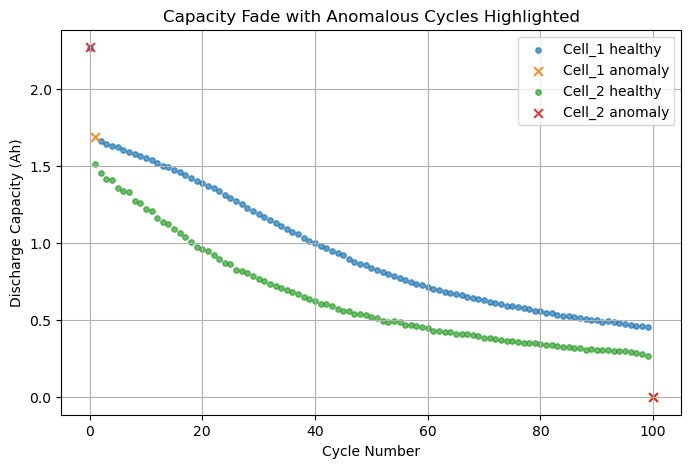

In [6]:
plt.figure(figsize=(8,5))

for cell_id, g in cycle_df_final.groupby("cell_id"):
    # normal points
    g_normal = g[~g["anomaly_any"]]
    g_anom   = g[g["anomaly_any"]]

    plt.scatter(g_normal["Cycle"], g_normal["Discharge_Ah"], s=15, alpha=0.7, label=f"{cell_id} healthy")
    plt.scatter(g_anom["Cycle"],   g_anom["Discharge_Ah"], s=40, alpha=0.9, marker="x", label=f"{cell_id} anomaly")

plt.xlabel("Cycle Number")
plt.ylabel("Discharge Capacity (Ah)")
plt.title("Capacity Fade with Anomalous Cycles Highlighted")
plt.grid(True)
plt.legend()
plt.show()


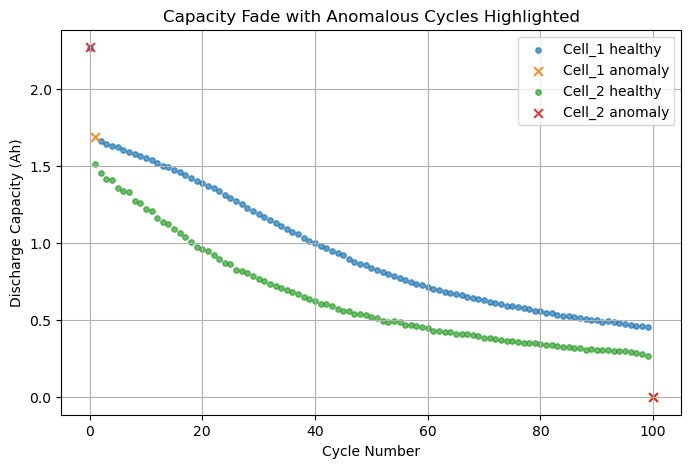

In [8]:
plt.figure(figsize=(8,5))

for cell_id, g in cycle_df_final.groupby("cell_id"):
    # normal points
    g_normal = g[~g["anomaly_any"]]
    g_anom   = g[g["anomaly_any"]]

    plt.scatter(g_normal["Cycle"], g_normal["Discharge_Ah"], s=15, alpha=0.7, label=f"{cell_id} healthy")
    plt.scatter(g_anom["Cycle"],   g_anom["Discharge_Ah"], s=40, alpha=0.9, marker="x", label=f"{cell_id} anomaly")

plt.xlabel("Cycle Number")
plt.ylabel("Discharge Capacity (Ah)")
plt.title("Capacity Fade with Anomalous Cycles Highlighted")
plt.grid(True)
plt.legend()
plt.show()


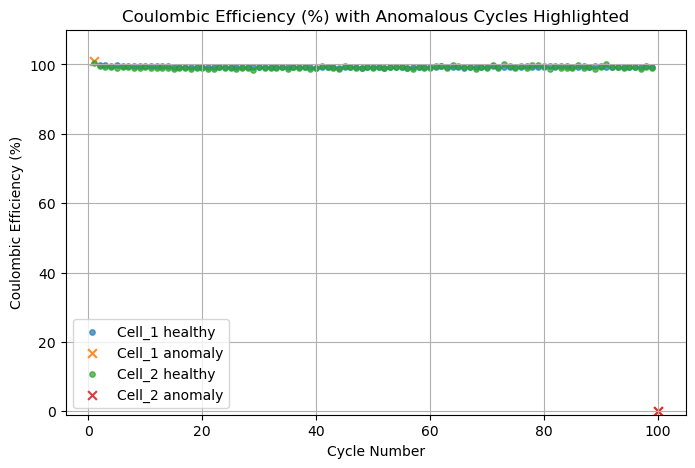

In [10]:
plt.figure(figsize=(8,5))

for cell_id, g in cycle_df_final.groupby("cell_id"):
    # normal points
    g_normal = g[~g["anomaly_any"]]
    g_anom   = g[g["anomaly_any"]]

    plt.scatter(g_normal["Cycle"], g_normal["Coulombic_Efficiency_%"], s=15, alpha=0.7, label=f"{cell_id} healthy")
    plt.scatter(g_anom["Cycle"],   g_anom["Coulombic_Efficiency_%"], s=40, alpha=0.9, marker="x", label=f"{cell_id} anomaly")

plt.xlabel("Cycle Number")
plt.ylabel("Coulombic Efficiency (%)")
plt.title("Coulombic Efficiency (%) with Anomalous Cycles Highlighted")
plt.ylim([-1,110])
plt.grid(True)
plt.legend()
plt.show()



#### Deviation Clusters (DBSCAN)

In [18]:
CELL_COL  = "cell_id"
CYCLE_COL = "Cycle"

Q_COL   = "Discharge_Ah"
COLEFF  = "Coulombic_Efficiency_%"


# Select all required columns INCLUDING Coulombic Efficiency
feat = before_filtered_cycle_df[
    [CELL_COL, CYCLE_COL, Q_COL, COLEFF]
].copy()

# Sort properly for dQ computation
feat = feat.sort_values([CELL_COL, CYCLE_COL])

# Capacity change per cycle
feat["dQ"] = feat.groupby(CELL_COL)[Q_COL].diff()

use_cols = ["dQ", Q_COL, COLEFF]

# Drop rows where any of these are missing
feat_clean = feat.dropna(subset=use_cols).copy()

X = feat_clean[use_cols].values
X_scaled = StandardScaler().fit_transform(X)

db = DBSCAN(eps=0.8, min_samples=10)
labels = db.fit_predict(X_scaled)

feat_clean["cluster"] = labels
feat_clean["is_outlier"] = feat_clean["cluster"] == -1

print(
    "Outlier cycles:",
    int(feat_clean["is_outlier"].sum()),
    "/",
    len(feat_clean)
)


Outlier cycles: 4 / 200


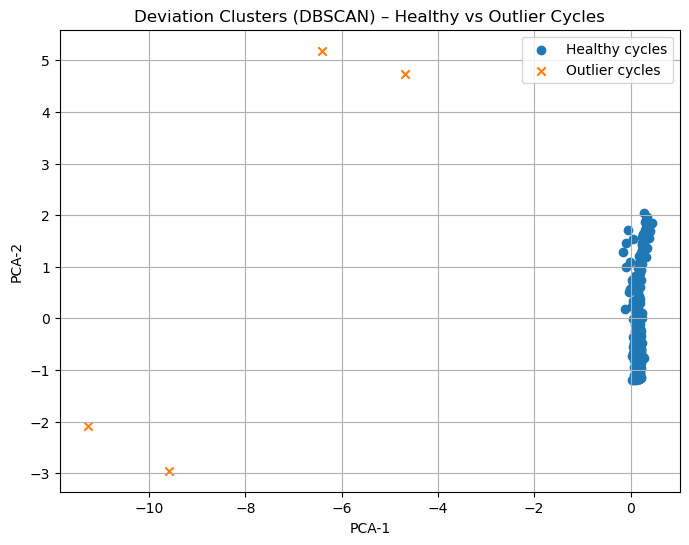

In [ ]:
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_scaled)

feat_clean["pc1"] = X_2d[:, 0]
feat_clean["pc2"] = X_2d[:, 1]

plt.figure(figsize=(8, 6))

plt.scatter(
    feat_clean.loc[~feat_clean["is_outlier"], "pc1"],
    feat_clean.loc[~feat_clean["is_outlier"], "pc2"],
    label="Healthy cycles"
)

plt.scatter(
    feat_clean.loc[feat_clean["is_outlier"], "pc1"],
    feat_clean.loc[feat_clean["is_outlier"], "pc2"],
    label="Outlier cycles",
    marker="x"
)

plt.title("Deviation Clusters (DBSCAN) – Healthy vs Outlier Cycles")
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.grid(True)
plt.legend()
plt.show()
